# In this notebook you will find....

## Importing libraries and datasets for time series analysis

## Create a subset of the data containing the necessary years

## Decomposing the data

## Dickey-fuller Test

## Stationarizing the data through differencing

## Plotting the Auto Correlation

### Importing libraries and datasets

In [31]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key

quandl.ApiConfig.api_key = 'zmKEgmYNBzhvjxyfXZsv'

In [3]:
# Import time series data
data = quandl.get('FMAC/HPI_NY')

In [4]:
data.head(5)

,NSA Value,SA Value
Date,,
1975-01-31,23.818861,23.839583
1975-02-28,23.279220,23.314171
1975-03-31,23.056193,23.128211
1975-04-30,23.081860,23.135118
1975-05-31,23.205026,23.194721


In [5]:
data.shape

(557, 2)

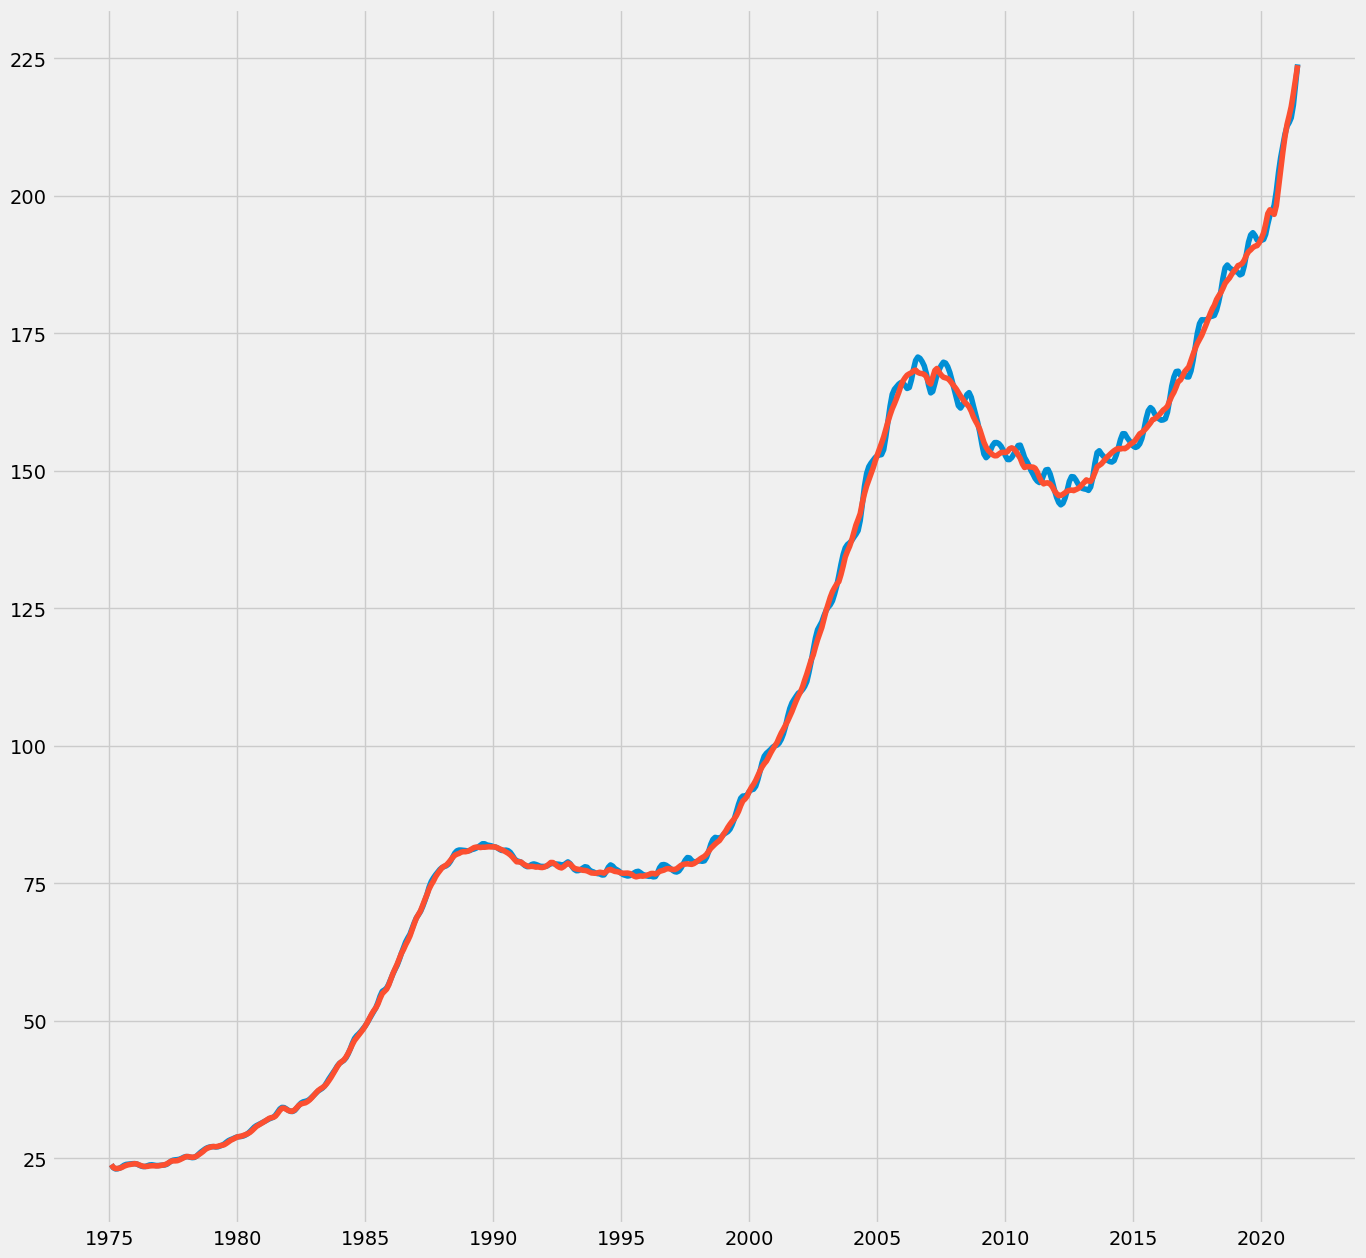

In [6]:
# Plot the data frame
plt.figure(figsize=(15,15), dpi=100)
plt.plot(data)

### Wrangling Data

#### Drop columns

In [7]:
data.drop('NSA Value', axis = 1, inplace = True)

In [8]:
data.head()

,SA Value
Date,
1975-01-31,23.839583
1975-02-28,23.314171
1975-03-31,23.128211
1975-04-30,23.135118
1975-05-31,23.194721


### Create subset of data

Since my Airbnb data is from 2019, I will only need the past 5 years for my analysis

In [9]:
# Reset the index of orignal data set so the date is a column
data_2 = data.reset_index()

In [10]:
# Create subset with filters
subset = data_2.loc[(data_2['Date']>='2015-01-01') & (data_2['Date']<= '2019-12-31')]

In [11]:
subset.head()

,Date,SA Value
480,2015-01-31,155.597598
481,2015-02-28,156.126064
482,2015-03-31,156.708079
483,2015-04-30,156.933911
484,2015-05-31,157.311889


In [12]:
subset.shape

(60, 2)

In [13]:
# Set 'Date' column as index
subset['datetime'] = pd.to_datetime(subset['Date'])
subset = subset.set_index('datetime')
subset.drop(['Date'], axis = 1, inplace = True)
subset.head()

,SA Value
datetime,
2015-01-31,155.597598
2015-02-28,156.126064
2015-03-31,156.708079
2015-04-30,156.933911
2015-05-31,157.311889


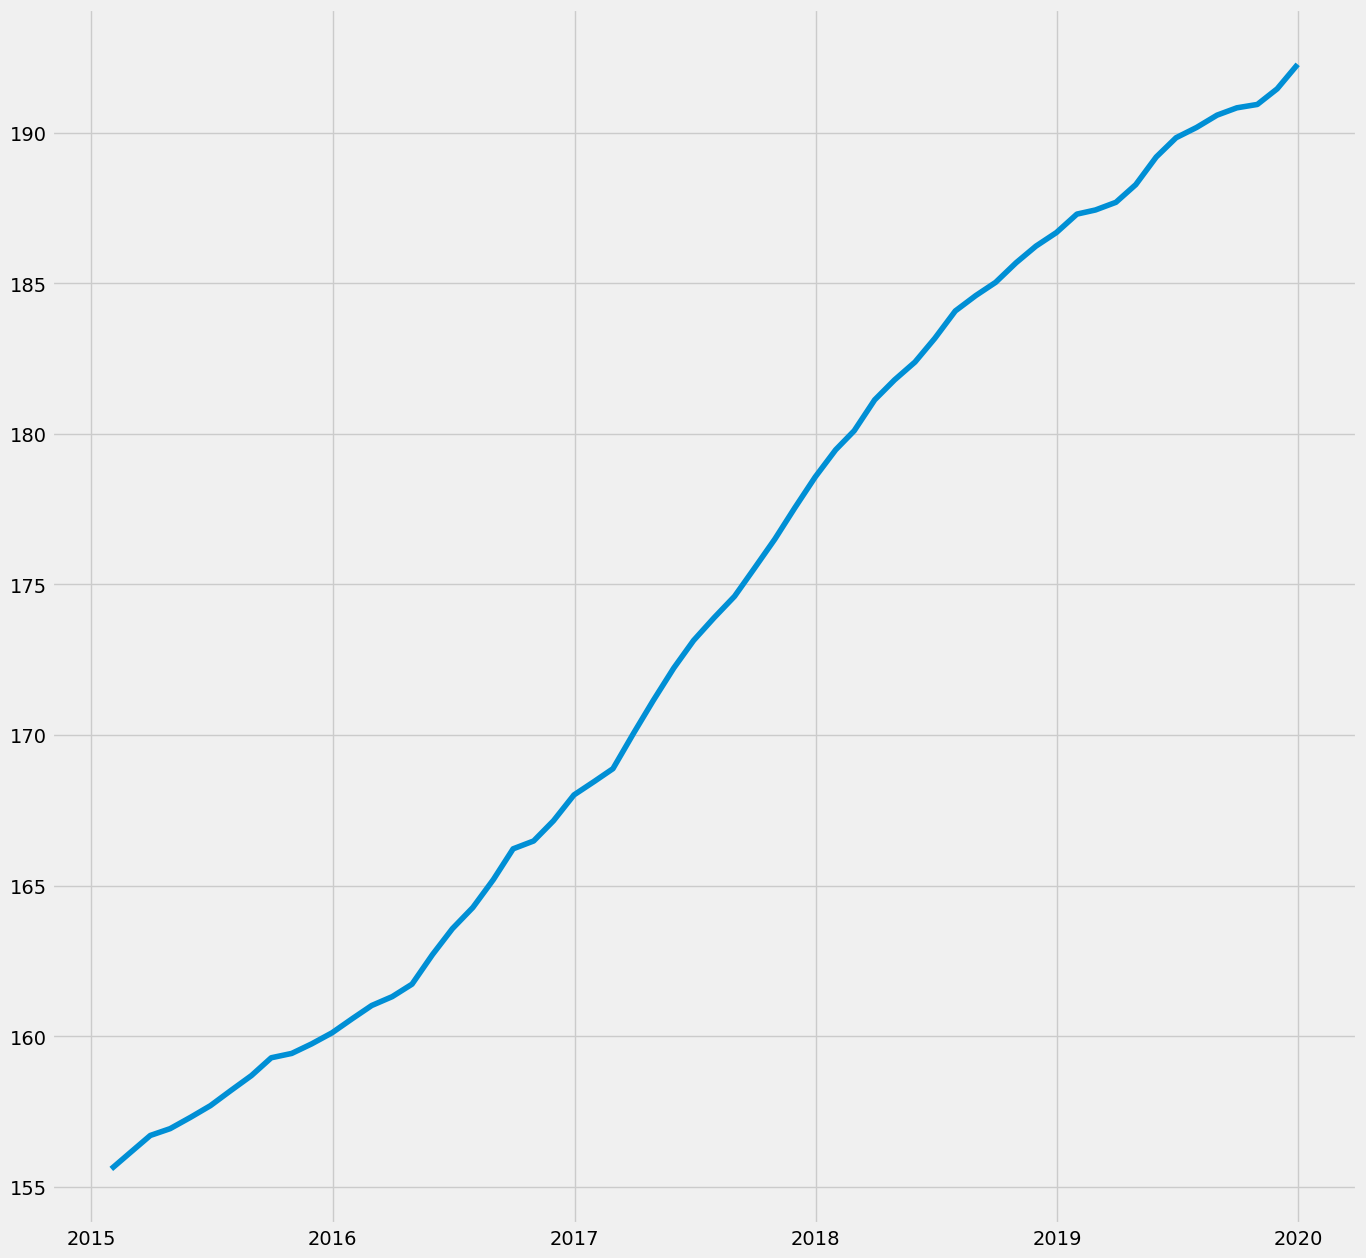

In [14]:
# Plot new data
plt.figure(figsize = (15,15), dpi=100)
plt.plot(subset)

In [43]:
# Check for missing values
subset.isnull().sum()

SA Value    0
dtype: int64

In [44]:
# Check for duplicates
dups = subset.duplicated()
dups.sum()

0

## Decomposition

In [15]:
# Decompose time series using additive model

decomposition = sm.tsa.seasonal_decompose(subset, model='additive')

In [16]:
# Define fixed size for all special charts
from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

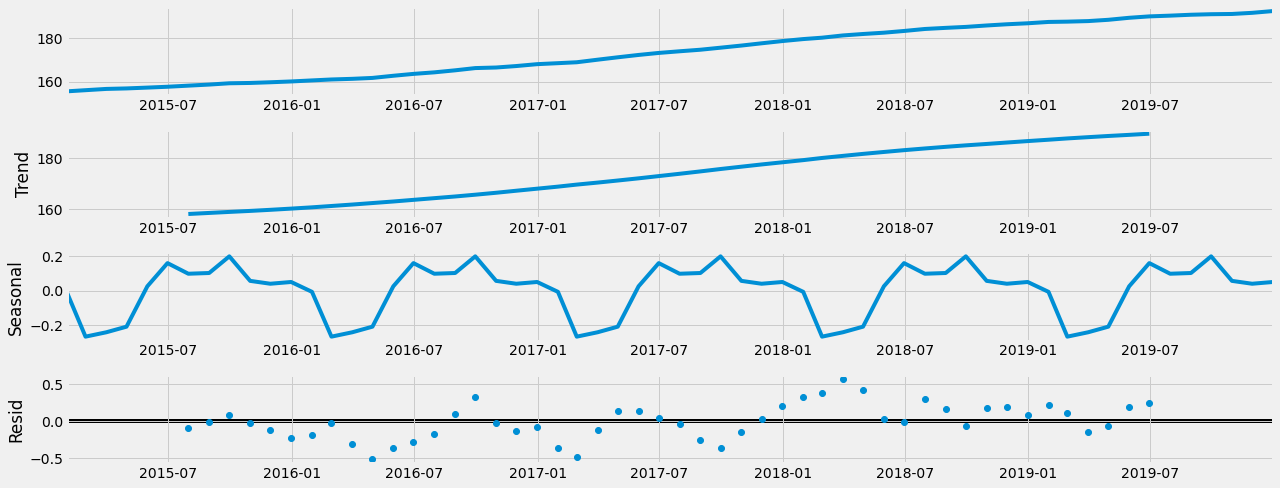

In [17]:
# Plot the decomposition
decomposition.plot()
plt.show()

From the trend line, we see that house prices are on an upward trend for the past 5 years. 

And the seasonal changes in a regular pattern. A rise in spring, then slight dip in later summer months and then another rise. Until it gradually drops to the spring low.

Then the noise, as we can see in the 'residual line' there is a lot of noise. We can see in 2016 and 2017 there are unexplainable dips. And then in 2018, we see unusual rises in the data.

### Stationarity Test

Null Hypothesis: there is a unit root

In [18]:
# Import addfuller() function
from statsmodels.tsa.stattools import adfuller

# DDefine the fucnction and perform Dickey-Fuller test:
def dickey_fuller(timeseries):
    print('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4],index = ['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        result['Critical Value (%s) '%key] = value
    print (result)
    
# Apply Dickey-Fuller test to the time series
dickey_fuller(subset['SA Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.269740
p-value                         0.642900
Number of Lags Used             6.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


As we can see, the test statistic is larger than the critical value (5%). So this means that the data is not stationarity since this shows us that there is a unit root in the data.

### Stationarizing 

In [19]:
data_diff = subset - subset.shift(1)

In [20]:
# Drop missing values that come about form differencing
data_diff.dropna(inplace = True)

In [21]:
data_diff.head()

,SA Value
datetime,
2015-02-28,0.528465
2015-03-31,0.582016
2015-04-30,0.225831
2015-05-31,0.377978
2015-06-30,0.385980


In [22]:
data_diff.columns

Index(['SA Value'], dtype='object')

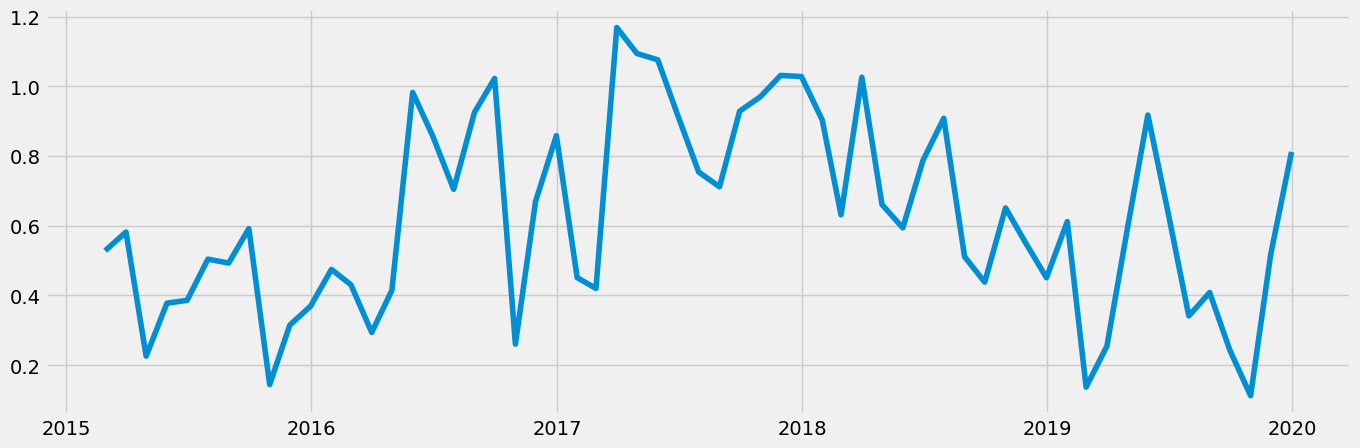

In [23]:
# Check to see the differencing
plt.figure(figsize=(15,5),dpi = 100)
plt.plot(data_diff)

In [24]:
# run Dickey-fuller test after differencing
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -1.345625
p-value                         0.608049
Number of Lags Used             5.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


In [25]:
# Run differencing on the subset again
data_diff_2 = data_diff - data_diff.shift(1)

In [26]:
# Drop missing values that came about differencing
data_diff_2.dropna(inplace = True)

In [27]:
data_diff_2.head()

,SA Value
datetime,
2015-03-31,0.053550
2015-04-30,-0.356184
2015-05-31,0.152147
2015-06-30,0.008002
2015-07-31,0.118236


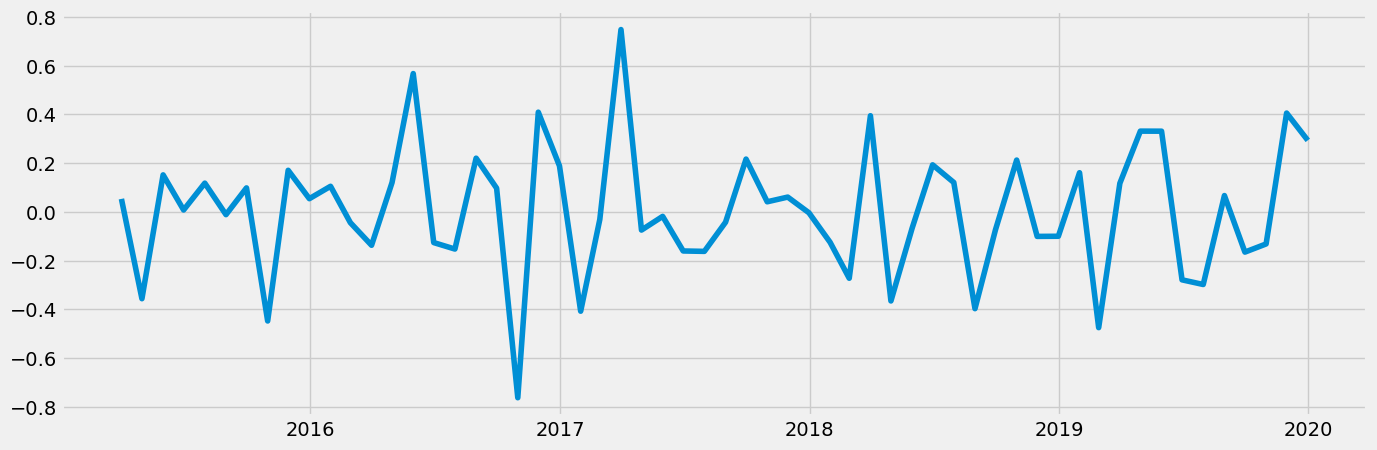

In [28]:
# Check to see the differencing
plt.figure(figsize=(15,5),dpi = 100)
plt.plot(data_diff_2)

In [29]:
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                -6.320455e+00
p-value                        3.075348e-08
Number of Lags Used            4.000000e+00
Number of Observations Used    5.300000e+01
Critical Value (1%)           -3.560242e+00
Critical Value (5%)           -2.917850e+00
Critical Value (10%)          -2.596796e+00
dtype: float64


The test statistic is now less than the critical value (5%) so our data is now stationarity.

### Autocorrelations

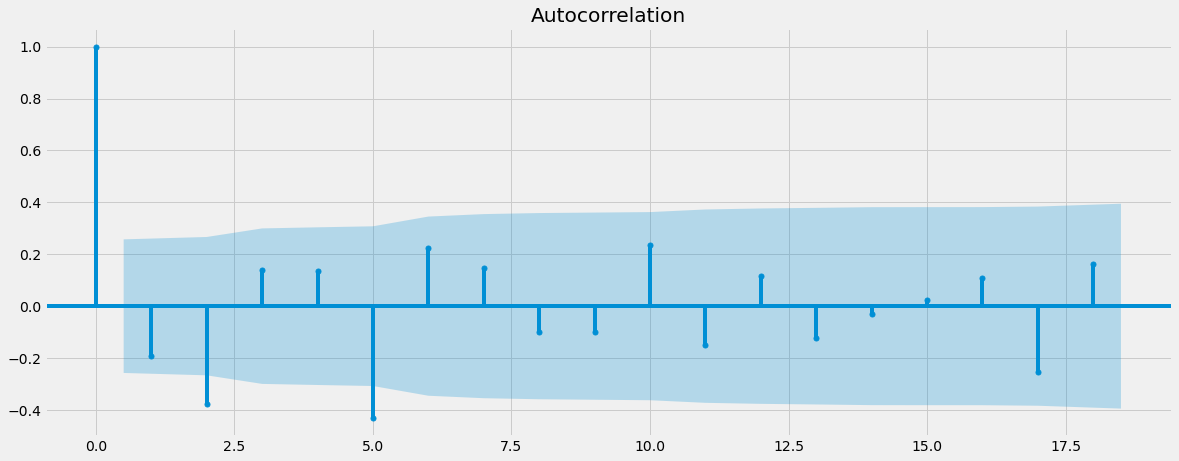

In [33]:
# Import plot_acf() function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot autocorrelation

plot_acf(data_diff_2)
plt.show()

There are 3 lines above the confidence level, meaning while technically the data is stationarity, it is stroner. So there is no need for us to difference it again.